In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.svm import SVR
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from plotly.offline import plot
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
import plotly.express as px
import math
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import Hyperparameter
import itertools 
import matplotlib.cm as cm 
from smt.sampling_methods import LHS
import dash
import dash_core_components as dcc
import dash_html_components as html
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import euclidean_distances
from scipy.special import softmax
import time
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 1000)
init_notebook_mode(connected=True)


class CREATE_DATA:
    def __init__(self,r1,r2,interval=None,num=None):
        self.r1=r1
        self.r2=r2
        self.interval=interval
        self.num=num

    
    def peak_function(self,x1,x2):
        y= np.cos(x1)*np.cos(x2)*(np.exp(-(x1+2)**2-(x2-2)**2)+0.5*np.exp(-(x1-2)**2-(x2+2)**2))
        return y

    def making_Grid(self):
        x1=np.arange(self.r1,self.r2+0.1,self.interval)
        x2=np.arange(self.r1,self.r2+0.1,self.interval)
        data=pd.DataFrame()
        for i in x1 :
            for z in x2:
                a=[[i,z]]
                data=data.append(a,ignore_index=True)
        data.columns=['x1','x2']
        data['y']=self.peak_function(data['x1'],data['x2'])

        return data

    def making_Random(self,r1,r2,num):
        x={'x1':np.random.uniform(self.r1,self.r2,self.num).T, 'x2':np.random.uniform(self.r1,self.r2,self.num).T}
        data=pd.DataFrame(x)
        data['y']=self.peak_function(data['x1'],data['x2'])
        return data

    def making_LHS(self,r1,r2,num):
        xlimits = np.array([[self.r1, self.r2], [self.r1, self.r2]])
        sampling = LHS(xlimits=xlimits,criterion='ese')
        x = sampling(self.num)
        data=pd.DataFrame(x,columns=['x1','x2'])
        data['y']=self.peak_function(data['x1'],data['x2'])
        return data


class QBC:
    def __init__(self,Committee_num):
        self.committee_num=Committee_num

    def peak_function(self,x1,x2):
        y= np.cos(x1)*np.cos(x2)*(np.exp(-(x1+2)**2-(x2-2)**2)+0.5*np.exp(-(x1-2)**2-(x2+2)**2))
        return y

    def committee(self,data,a):
        qbc1=data.sample(n=len(data),replace=True)

        x_qbc1=qbc1[['x1','x2']]
        y_qbc1=qbc1['y']

        kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
        qbc_model1 = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=a, normalize_y=True,random_state=42)
        qbc_model1.fit(x_qbc1, y_qbc1)
        return qbc_model1

    def LOO(self,lhs_init):
        MSE=pd.DataFrame()
        for i in range(len(lhs_init)):
            x_true=lhs_init[['x1','x2']]
            y_true=lhs_init['y'] 

            sub_x=x_true.drop(x_true.index[i:i+1])
            sub_y=y_true.drop(y_true.index[i:i+1])

            #sub를 제외한 나머지 labeled data로 모델 생성
            r2,rmse=self.model_gp(sub_x,sub_y,x_true,y_true)
            MSE=MSE.append([rmse],ignore_index=True)

        MSE.columns=['rmse']
        var_df=pd.merge(lhs_init,MSE,left_index=True,right_index=True)
        var_df['probability']=var_df['rmse']/sum(var_df['rmse'])
        var_df.sort_values(by=['rmse'],ascending=False,inplace=True)
        var_df.reset_index(drop=True,inplace=True)
        return var_df

    def model_gp(self,train_x,train_y,test_x,test_y):
        kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RationalQuadratic(length_scale=1.0, alpha=1.5)
        model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True,random_state=42)
        model.fit(train_x, train_y)
        y_pred, std = model.predict(test_x, return_std=True)   
        rmse=mean_squared_error(test_y,y_pred,squared=False)
        r2=r2_score(test_y,y_pred)
        
        return r2,rmse


    def training(self,candidates_num,newpoints_file,result_file,prob,save_train):
        test_df=pd.read_csv('D:\\Active-learning\\peak1_test10000.csv')
        test_x=test_df.drop('y',axis=1)
        test_y=test_df['y']
        loss = pd.DataFrame()
        for z in range(1):
            lhs_init=pd.read_csv('D:\\Active-learning\\new_lhs_init_peak1.csv')
            NEW_POINTS=pd.DataFrame()

            init_n=0
            start=datetime.now()
            while len(lhs_init)<81:

                #test set에서 랜덤으로 20개 가져오기
                candidates=test_df.sample(20)
                candidates.reset_index(drop=True, inplace=True)
                #y버리기
                candi_x=candidates.drop('y',axis=1)

                #qbc 모델 만들기
                qbc1=self.committee(lhs_init,0.1)
                qbc2=self.committee(lhs_init,0.2)
                qbc3=self.committee(lhs_init,0.3)
                qbc4=self.committee(lhs_init,0.4)
                qbc5=self.committee(lhs_init,0.5)

                #후보군 중에서 1개 선택

                var=[]
                for i in range(len(candi_x)):
                    x_loo=candi_x[i:i+1]

                    pred1=qbc1.predict(x_loo)
                    pred2=qbc2.predict(x_loo)
                    pred3=qbc3.predict(x_loo)
                    pred4=qbc4.predict(x_loo)
                    pred5=qbc5.predict(x_loo)
                    p=[pred1,pred2,pred3,pred4,pred5]
                    v=np.var(p)
                    var.append(v)
                Var=pd.DataFrame(data=var,columns=['var'])
                can_prior=pd.merge(candidates,Var,left_index=True,right_index=True)

                can_prior['probability']=can_prior['var']/sum(can_prior['var'])
                can_prior['p_root']=(can_prior['var']/sum(can_prior['var']))**0.5
                can_prior['p_square']=(can_prior['var']/sum(can_prior['var']))**2
                init_points=lhs_init[['x1','x2']]
                dist=pd.DataFrame(distance.cdist(init_points, candi_x, 'euclidean'))

                # 이니셜 과 새로운 후보들 간의 평균 거리 중 가장 멀리 있는 후보 선택
                dist_mean=pd.DataFrame(dist.mean(),columns=['dist_mean'])

                # 후보군과 가장 가까운 이니셜과의 거리가 가장 먼것 
                dist_min=pd.DataFrame(dist.min(),columns=['dist_min'])

                can_prior=pd.merge(can_prior,dist_mean,right_index=True, left_index=True)
                can_prior=pd.merge(can_prior,dist_min,right_index=True, left_index=True)
                can_prior['dist_mean_prob'] = can_prior['dist_mean'] / sum(can_prior['dist_mean'])
                can_prior['dist_min_prob'] = can_prior['dist_min'] / sum(can_prior['dist_min'])

                
                can_prior['v*mean*min']=(can_prior['probability'])*(can_prior['dist_mean_prob'])*(can_prior['dist_min_prob'])
                #can_prior['v*mean*min11']=(can_prior['probability']*0.3)+(can_prior['dist_mean_prob']*0.3)+(can_prior['dist_min_prob']*0.4)
                #can_prior['v*mean*min12']=(can_prior['probability']*(0.1+init_n*(0.3/(81-20))))*(can_prior['dist_mean_prob']*(0.3-init_n*(0.1/(81-20))))*(can_prior['dist_min_prob']*(0.6-init_n*(0.2/(81-20))))
                
                can_prior['vmm_prob']=can_prior[prob] / sum(can_prior[prob])

                can_prior.sort_values(by=['vmm_prob'],ascending=False,inplace=True)
                can_prior.reset_index(drop=True,inplace=True)

                new_x=can_prior.iloc[0]
                new_x['y']=self.peak_function(new_x['x1'],new_x['x2'])
                new_point=new_x[['x1','x2','y']]
                new_point.columns=['x1','x2','y']

                lhs_init=lhs_init.append(new_point,ignore_index=True)
                NEW_POINTS=NEW_POINTS.append(new_point,ignore_index=True)  

                #r2확인하기
                train_x=lhs_init.drop('y',axis=1)
                train_y=lhs_init['y']

                r2,rmse=self.model_gp(train_x,train_y,test_x,test_y)
                init_n+=1
                print('points:',len(lhs_init),'   r2:',r2, '    rmse: ',rmse) 
                    
            finish=datetime.now()
            run_time=finish-start
            print(run_time)
            print('total points:',len(lhs_init),'   r2:',r2, '    rmse: ',rmse) 
                
            loss=loss.append([[r2,rmse]],ignore_index=True)

            # 결과 파일
            self.save_newpoints(newpoints_file,z,NEW_POINTS)  
            self.save_newpoints(save_train,z,lhs_init) 

            #그래프
            self.graph(NEW_POINTS)


        print(prob, loss.mean())

        self.save_result(result_file,candidates_num,prob,run_time,loss) 
            
        return loss


    #새로운 data point 저장
    def save_newpoints(self,file_name,z,NEW_POINTS):
        f = open(file_name,'a')
        time = "%d TIME.\n\n" %z
        f.write(time)
        f.close()
        result=pd.read_csv(file_name, sep = '\t',encoding='EUC-KR')
        result=result.append(NEW_POINTS)
        result.to_csv(file_name, sep = '\t',index=False)
        return 

    #결과 파일 저장
    def save_result(self,file_name,candidates_num,prob,run_time,loss):
        f = open(file_name,'a')
        time = "candidates_num : %d,     prob : %s,  run_time : %s \n\n" %(candidates_num,prob,run_time)
        f.write(time)
        f.close()
        result=pd.read_csv(file_name, sep = '\t',encoding='EUC-KR')
        result=result.append(loss)
        result.to_csv(file_name, sep = '\t',index=True)
        return 

    #그래프
    def graph(self,NEW_POINTS):
        init=pd.read_csv('new_lhs_init_peak1.csv')

        X=NEW_POINTS['x1']
        Y=NEW_POINTS['x2']
        labels=range(0,len(NEW_POINTS))

        fig = plt.figure()
        ax = fig.add_subplot(111)


        for x,y,lab in zip(X,Y,labels):
                ax.scatter(x,y,label=lab)

        colormap = plt.cm.Reds
        colorst = [colormap(i) for i in np.linspace(0.9, 0,len(ax.collections))]       
        for t,j1 in enumerate(ax.collections):
            j1.set_color(colorst[t])

        return ax.scatter(init['x1'], init['x2'], s=10, c='b', marker="s", label='init')



points: 21    r2: -0.0851018049355603     rmse:  0.03538088652835538
points: 22    r2: 0.20937874410820145     rmse:  0.030200748788114334
points: 23    r2: 0.20911310216255397     rmse:  0.03020582195800544
points: 24    r2: 0.23923490916208445     rmse:  0.029625027061703915
points: 25    r2: 0.019867154790206953     rmse:  0.03362605657227424
points: 26    r2: 0.06547207968942192     rmse:  0.032834439592193745
points: 27    r2: -0.11986992521175055     rmse:  0.03594324296074723
points: 28    r2: -0.12342551031053572     rmse:  0.03600025760874747
points: 29    r2: -0.07088814886431627     rmse:  0.03514839707005902
points: 30    r2: -0.02140950637499528     rmse:  0.034326807577259276
points: 31    r2: -0.3346511712015787     rmse:  0.03923894784856863
points: 32    r2: -0.2658779070499868     rmse:  0.038214605264493
points: 33    r2: -0.22443940799059003     rmse:  0.037583923643723864
points: 34    r2: -0.17452811368710996     rmse:  0.036809945636247295
points: 35    r2: -0.12

,0,1
0,0.470386,0.024718


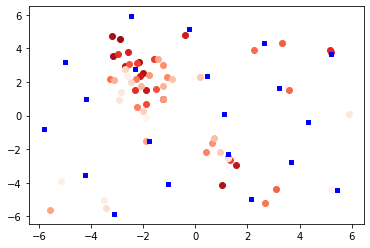

In [14]:
QBC.training(20,'D:\\Active-learning\\qbc_vmm\\qbc_newpoint.txt','D:\\Active-learning\\qbc_vmm\\qbc_loss.txt','probability','D:\\Active-learning\\qbc_vmm\\qbc_train_all81.txt')

In [53]:
train=pd.read_csv('D:\\Active-learning\\qbc_vmm\\qbc_vmm_train_all81.txt',sep='\t')
train=train.iloc[246:327][['x1','x2','y']]
train

,x1,x2,y
246,2.138345,-4.971050,-9.894413e-06
247,-4.260634,-3.527242,1.318849e-16
248,1.239350,-2.267406,-5.449395e-02
249,-2.472615,5.912177,-1.318341e-07
250,5.457859,-4.410026,-1.945565e-09
251,2.639835,4.321852,6.801937e-13
252,-5.816021,-0.819503,1.019215e-10
253,3.220729,1.648986,1.447000e-08
254,3.664565,-2.768195,1.399687e-02
255,-4.199777,0.971207,-7.601301e-04


In [2]:
grid=CREATE_DATA.making_Grid(-6,6,1.5)
len(grid)

81

In [3]:
random_df=CREATE_DATA.making_Random(-6,6,81)
len(random_df)

81

In [4]:
lhs=CREATE_DATA.making_LHS(-6,6,81)
len(lhs)

81

In [19]:
grid

,x1,x2,y
0,-6.0,-6.0,2.495912e-35
1,-6.0,-4.5,-1.019901e-26
2,-6.0,-3.0,-1.485615e-18
3,-6.0,-1.5,3.657438e-14
4,-6.0,0.0,1.979058e-09
5,-6.0,1.5,5.952656e-09
6,-6.0,3.0,-3.935265e-08
7,-6.0,4.5,-4.397015e-11
8,-6.0,6.0,1.167544e-14
9,-4.5,-6.0,-5.099552e-27


In [27]:
 # 3d 그래프
initial=go.Scatter3d(
    x=test_df['x1'],
    y=test_df['x2'],
    z=test_df['y'],
    mode='markers',
    marker=dict(
        size=2,
        color='blue',
       opacity=0.6))  

# new=go.Scatter3d(
#     x=new_point['L'],
#     y=new_point['v0'],
#     z=new_point['C'],
#     mode='markers',
#     marker=dict(
#         size=3,
#         color= 'red'),
#        opacity=0.6))
    

fig = go.Figure(data=[initial])

fig.update_layout(scene = dict(
    zaxis = dict(nticks=4, range=[-0.1,0.4],tickvals= [-0.1,0,0.1,0.2,0.3,0.4]),
                    xaxis_title='x1',
                    yaxis_title='x2',
                    zaxis_title='y'),
                    width=800,
                    margin=dict(r=50, b=0, l=50, t=0))

fig

# 분산 0.5 최소거리 0.5, 가중치 업데이트 vmm9

In [23]:
QBC.training(20,'D:\\Active-learning\\QBC_update\\qbc_distnace_points.txt','D:\\Active-learning\\QBC_update\\qbc_distnace_points_loss.txt','v*mean*min9')

0:01:30.044915
total points: 81    r2: 0.638616782642368     rmse:  0.020418200201685437
0:01:30.826565
total points: 81    r2: 0.5770931501543297     rmse:  0.02208797120719858
0:01:30.651205
total points: 81    r2: 0.6538689350798572     rmse:  0.01998268107356443
0:01:29.360359
total points: 81    r2: 0.4090433229226683     rmse:  0.026110265609887932
0:01:27.889141
total points: 81    r2: 0.34604063561606413     rmse:  0.027466849589132206
0:01:29.859169
total points: 81    r2: 0.34347945575538696     rmse:  0.02752058289638356
0:01:31.027285
total points: 81    r2: 0.39353786723991346     rmse:  0.0264505868610756
0:01:30.312340
total points: 81    r2: 0.5246098075241326     rmse:  0.02341847316902586
0:01:31.489594
total points: 81    r2: 0.7638337892272773     rmse:  0.016506019297333068
0:01:30.763246
total points: 81    r2: 0.608673058873821     rmse:  0.021247280034957315
v*mean*min9 0    0.525880
1    0.023121
dtype: float64


,0,1
0,0.638617,0.020418
1,0.577093,0.022088
2,0.653869,0.019983
3,0.409043,0.026110
4,0.346041,0.027467
5,0.343479,0.027521
6,0.393538,0.026451
7,0.524610,0.023418
8,0.763834,0.016506
9,0.608673,0.021247


# single-pendulum 조건 동일

points: 21    r2: 0.05815790369150786     rmse:  0.0329626801678687
points: 22    r2: -0.01679469812781642     rmse:  0.03424917418530591
points: 23    r2: -0.01693823960417906     rmse:  0.03425159158753233
points: 24    r2: -0.01442981208128713     rmse:  0.03420932221499118
points: 25    r2: -0.01228849016392819     rmse:  0.03417319755251477
points: 26    r2: 0.3677484003471133     rmse:  0.027007130076948972
points: 27    r2: 0.3709812146454263     rmse:  0.026937995471989332
points: 28    r2: 0.5089686438572998     rmse:  0.02380060960539827
points: 29    r2: 0.5099745447292705     rmse:  0.023776218772384273
points: 30    r2: 0.48592489073187506     rmse:  0.024352679660312123
points: 31    r2: 0.35306852773729325     rmse:  0.02731886219820805
points: 32    r2: 0.37381041154142447     rmse:  0.026877346421681755
points: 33    r2: 0.39189477847811083     rmse:  0.026486393931681316
points: 34    r2: 0.3999939191033751     rmse:  0.026309421191340682
points: 35    r2: 0.297024373

points: 78    r2: 0.7116002649906501     rmse:  0.018240254611909937
points: 79    r2: 0.6912461195644619     rmse:  0.01887294525001099
points: 80    r2: 0.6945685189048589     rmse:  0.018771127813204953
points: 81    r2: 0.689571292503885     rmse:  0.018924063910948485
0:01:28.817682
total points: 81    r2: 0.689571292503885     rmse:  0.018924063910948485
points: 21    r2: 0.18908150576184102     rmse:  0.030585956772533802
points: 22    r2: 0.18941298786408967     rmse:  0.030579704767158322
points: 23    r2: 0.23484615592335445     rmse:  0.029710355608799616
points: 24    r2: 0.24589900101107875     rmse:  0.029494988136094975
points: 25    r2: 0.2554541060119744     rmse:  0.029307529055862386
points: 26    r2: 0.2726208058235635     rmse:  0.028967692719300733
points: 27    r2: 0.27969297559657447     rmse:  0.02882652505694548
points: 28    r2: 0.2873166571155258     rmse:  0.02867357025493298
points: 29    r2: 0.29282412008966485     rmse:  0.028562563801003187
points: 30  

points: 73    r2: 0.5632281422291049     rmse:  0.022447128450250986
points: 74    r2: 0.5304948309493243     rmse:  0.023273068981800833
points: 75    r2: 0.5485544138333946     rmse:  0.022821078947266028
points: 76    r2: 0.5564030413858188     rmse:  0.022621830692829983
points: 77    r2: 0.5841967945351173     rmse:  0.021901677728981887
points: 78    r2: 0.587668245068665     rmse:  0.021810059931827483
points: 79    r2: 0.5917799774838445     rmse:  0.021701043570714063
points: 80    r2: 0.5959408746415817     rmse:  0.021590163313710994
points: 81    r2: 0.6738768802634816     rmse:  0.01939653979795223
0:01:31.252169
total points: 81    r2: 0.6738768802634816     rmse:  0.01939653979795223
points: 21    r2: -0.08500390671267444     rmse:  0.035379290455052566
points: 22    r2: 0.1413039697079871     rmse:  0.031474090942251697
points: 23    r2: 0.13388750688544726     rmse:  0.03160971784773665
points: 24    r2: 0.2243960848732669     rmse:  0.029912551827118033
points: 25    

points: 67    r2: 0.31216722450278467     rmse:  0.02816922514174683
points: 68    r2: 0.3406569162680497     rmse:  0.027579678245788566
points: 69    r2: 0.3626853708964406     rmse:  0.02711505011908258
points: 70    r2: 0.38771477784895514     rmse:  0.02657726927295692
points: 71    r2: 0.42932613103845096     rmse:  0.025658275332773095
points: 72    r2: 0.4510496443065338     rmse:  0.02516517779973653
points: 73    r2: 0.46941568316874915     rmse:  0.024740625316411406
points: 74    r2: 0.4829112312375319     rmse:  0.024423956636796258
points: 75    r2: 0.49965531748452285     rmse:  0.024025260873605465
points: 76    r2: 0.5132545832286027     rmse:  0.023696510816225244
points: 77    r2: 0.5252855338015308     rmse:  0.023401823577562875
points: 78    r2: 0.5390237091773109     rmse:  0.02306071467041247
points: 79    r2: 0.5445655514721234     rmse:  0.02292167794425764
points: 80    r2: 0.511611152734495     rmse:  0.023736481148337398
points: 81    r2: 0.5310342912286005

points: 62    r2: 0.56430628659767     rmse:  0.022419406656848453
points: 63    r2: 0.5781355635978609     rmse:  0.02206073234363653
points: 64    r2: 0.6057870176051243     rmse:  0.021325485591069834
points: 65    r2: 0.5590891968067961     rmse:  0.022553234615102447
points: 66    r2: 0.5700017501714993     rmse:  0.022272389437109085
points: 67    r2: 0.5811180023919839     rmse:  0.02198261307370749
points: 68    r2: 0.595309671031544     rmse:  0.021607020340489995
points: 69    r2: 0.6214672653015515     rmse:  0.02089705996365866
points: 70    r2: 0.6329337112780273     rmse:  0.020578121076652998
points: 71    r2: 0.6453346173933012     rmse:  0.02022753066336963
points: 72    r2: 0.6528727612148106     rmse:  0.02001141574169364
points: 73    r2: 0.5813690188904617     rmse:  0.02197602550786505
points: 74    r2: 0.5817639635140024     rmse:  0.021965656756461872
points: 75    r2: 0.6067472867188615     rmse:  0.021299496224832765
points: 76    r2: 0.6126546615715506     rm

points: 56    r2: 0.21110932490750867     rmse:  0.030167677663735452
points: 57    r2: 0.24016395791671763     rmse:  0.029606932446962383
points: 58    r2: 0.16292026945146132     rmse:  0.031075410956763826
points: 59    r2: 0.19041987542398797     rmse:  0.030560706256505924
points: 60    r2: 0.185004739993052     rmse:  0.030662743439788465
points: 61    r2: 0.06178109255285458     rmse:  0.03289921671847116
points: 62    r2: 0.0984265973465348     rmse:  0.032250318891742784
points: 63    r2: 0.13321571478017447     rmse:  0.031621974363461536
points: 64    r2: 0.10651498641186052     rmse:  0.03210532746868677
points: 65    r2: 0.13710697312470432     rmse:  0.03155091418967988
points: 66    r2: 0.16592742756515166     rmse:  0.031019542471932168
points: 67    r2: 0.2101356677749604     rmse:  0.030186288554912902
points: 68    r2: 0.32634123380711366     rmse:  0.027877475995682067
points: 69    r2: 0.34760561100516696     rmse:  0.027433964754571282
points: 70    r2: 0.3447779

TypeError: save_result() takes 4 positional arguments but 5 were given

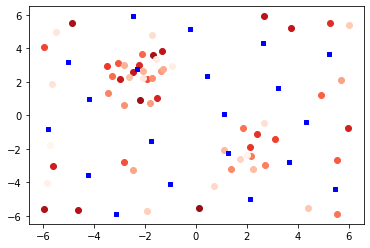

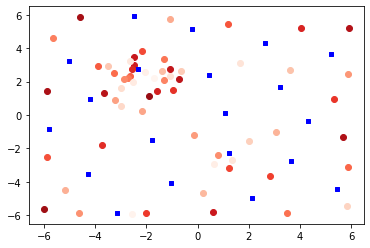

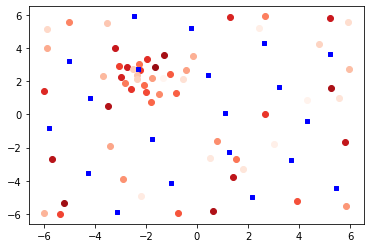

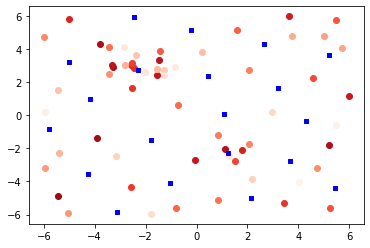

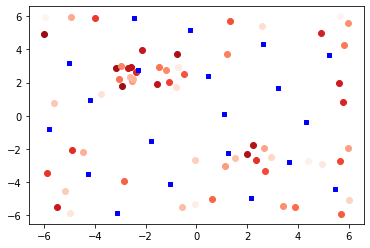

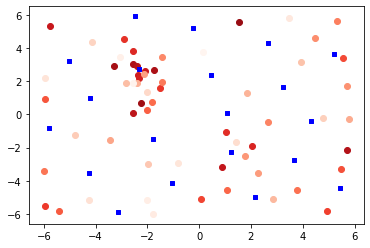

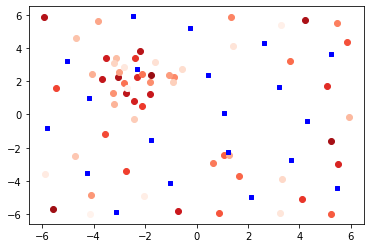

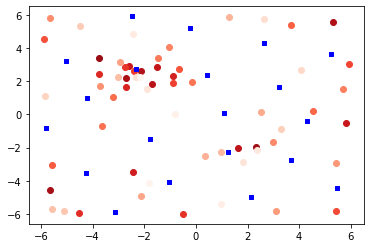

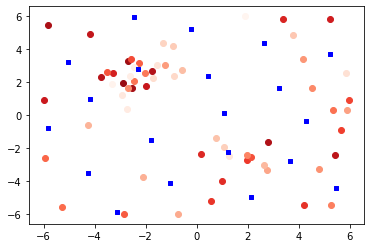

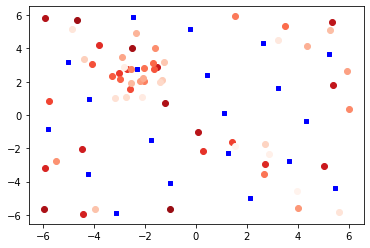

In [28]:
QBC.training(20,'D:\\Active-learning\\QBC_update\\qbc_distnace_points_single_condition.txt','D:\\Active-learning\\QBC_update\\qbc_distnace_points_single_condition_loss.txt','v*mean*min')

# vmm : weight 없음

points: 21    r2: -0.08500390671438485     rmse:  0.03537929045508045
points: 22    r2: -0.07863840386788179     rmse:  0.03527535614831214
points: 23    r2: -0.06965794608543874     rmse:  0.03512820257961521
points: 24    r2: -0.06190364571054241     rmse:  0.03500064306284658
points: 25    r2: -0.05517332096034755     rmse:  0.03488955005762204
points: 26    r2: -0.04930404283514589     rmse:  0.03479238022546755
points: 27    r2: 0.36351389518679444     rmse:  0.027097419279622538
points: 28    r2: 0.3653260417601176     rmse:  0.027058817103979622
points: 29    r2: 0.3595434641498435     rmse:  0.027181805387622823
points: 30    r2: 0.38986978931682903     rmse:  0.02653045709879264
points: 31    r2: 0.46519108523973285     rmse:  0.024838924461011838
points: 32    r2: -0.09934331022356813     rmse:  0.035612309307194376
points: 33    r2: 0.44428588409788594     rmse:  0.025319736520445404
points: 34    r2: 0.4551781275267758     rmse:  0.025070369508080458
points: 35    r2: 0.466

points: 78    r2: 0.8484363233716878     rmse:  0.013223031535326455
points: 79    r2: 0.8604680746061273     rmse:  0.012687330736138222
points: 80    r2: 0.845876022996051     rmse:  0.013334249322241472
points: 81    r2: 0.8548673015174674     rmse:  0.012939458525436263
0:01:36.522998
total points: 81    r2: 0.8548673015174674     rmse:  0.012939458525436263
points: 21    r2: -0.04025387803313496     rmse:  0.03464201452940845
points: 22    r2: -0.5945796486411854     rmse:  0.042890052341831846
points: 23    r2: 0.3341179283863881     rmse:  0.027716100583932937
points: 24    r2: 0.34328666752520176     rmse:  0.02752462332974955
points: 25    r2: 0.351926324285567     rmse:  0.027342968258197507
points: 26    r2: 0.3588980883428936     rmse:  0.02719549723205299
points: 27    r2: 0.33074880476385937     rmse:  0.027786128863003717
points: 28    r2: 0.34185781712596264     rmse:  0.027554550543003622
points: 29    r2: 0.3799181454515407     rmse:  0.02674594696780097
points: 30   

points: 73    r2: 0.7370380434493269     rmse:  0.017417263772071274
points: 74    r2: 0.7447701402022375     rmse:  0.017159285836884194
points: 75    r2: 0.754657530619133     rmse:  0.016823634859069674
points: 76    r2: 0.7631229039620302     rmse:  0.016530843062497098
points: 77    r2: 0.7691275518928239     rmse:  0.016319976227817168
points: 78    r2: 0.778025325933128     rmse:  0.016002402185071082
points: 79    r2: 0.7591908865315345     rmse:  0.016667479405801253
points: 80    r2: 0.7715967731990214     rmse:  0.016232469119493567
points: 81    r2: 0.7768267366405702     rmse:  0.01604554784086503
0:01:35.687146
total points: 81    r2: 0.7768267366405702     rmse:  0.01604554784086503
points: 21    r2: -0.06378723335277603     rmse:  0.0350316710991207
points: 22    r2: -0.19449778886612323     rmse:  0.0371215535104908
points: 23    r2: -0.009399341898796765     rmse:  0.03412439625582583
points: 24    r2: -0.008210584629549933     rmse:  0.0341042963940212
points: 25    

points: 68    r2: 0.58376612834694     rmse:  0.021913017072731824
points: 69    r2: 0.5932425804858266     rmse:  0.021662132577962737
points: 70    r2: 0.6144280613674462     rmse:  0.021090466076656787
points: 71    r2: 0.6220970669548627     rmse:  0.020879668493151805
points: 72    r2: 0.6769962837172491     rmse:  0.01930355188716771
points: 73    r2: 0.6894119611048912     rmse:  0.018928919793647338
points: 74    r2: 0.689733911960448     rmse:  0.018919106534181135
points: 75    r2: 0.7822333128503891     rmse:  0.015849997203118315
points: 76    r2: 0.7891732059018961     rmse:  0.015595394680817873
points: 77    r2: 0.7814932456593379     rmse:  0.015876906998135994
points: 78    r2: 0.783868252746923     rmse:  0.015790386123015872
points: 79    r2: 0.7935546887016727     rmse:  0.015432489127161055
points: 80    r2: 0.8001747448541214     rmse:  0.015183037191166914
points: 81    r2: 0.8071044661562147     rmse:  0.014917448733141651
0:01:37.961487
total points: 81    r2: 

points: 63    r2: 0.5444187309276911     rmse:  0.022925372331080884
points: 64    r2: 0.5769811584403579     rmse:  0.022090895617160912
points: 65    r2: 0.5926895915978784     rmse:  0.0216768524692844
points: 66    r2: 0.6082840548949001     rmse:  0.02125783798864452
points: 67    r2: 0.6217651510241968     rmse:  0.02088883589160938
points: 68    r2: 0.6349689492280965     rmse:  0.020520992991514254
points: 69    r2: 0.6329159299053579     rmse:  0.020578619491816337
points: 70    r2: 0.6443823827876146     rmse:  0.020254666725050913
points: 71    r2: 0.6544145657481838     rmse:  0.01996692481100961
points: 72    r2: 0.6622192200542399     rmse:  0.019740172108887063
points: 73    r2: 0.6681014891738718     rmse:  0.019567535016045478
points: 74    r2: 0.6756747010085018     rmse:  0.019343002205056286
points: 75    r2: 0.7203597693991806     rmse:  0.017961115000568562
points: 76    r2: 0.7265277686304132     rmse:  0.017761927166033344
points: 77    r2: 0.7640131688350038   

points: 58    r2: 0.5060996780856075     rmse:  0.023870038658873546
points: 59    r2: 0.5128946280439177     rmse:  0.023705271150951397
points: 60    r2: 0.5256760612590696     rmse:  0.023392195753190455
points: 61    r2: 0.5415899479333623     rmse:  0.022996435993577383
points: 62    r2: 0.5573006630250958     rmse:  0.022598931384102385
points: 63    r2: 0.5704513911822899     rmse:  0.022260741483789613
points: 64    r2: 0.5777612110126882     rmse:  0.022070518260847903
points: 65    r2: 0.5809095809601283     rmse:  0.02198808129380604
points: 66    r2: 0.5939928267655539     rmse:  0.021642145929272005
points: 67    r2: 0.600886481483214     rmse:  0.02145762676329851
points: 68    r2: 0.609813394013899     rmse:  0.02121629993335556
points: 69    r2: 0.6185997777889765     rmse:  0.020976061063666684
points: 70    r2: 0.6009103079541589     rmse:  0.02145698625987344
points: 71    r2: 0.5923620014744692     rmse:  0.021685567807005604
points: 72    r2: 0.5996454742959573    

,0,1
0,0.684685,0.019072
1,0.854867,0.012939
2,0.642711,0.020302
3,0.776827,0.016046
4,0.719261,0.017996
5,0.807104,0.014917
6,0.858499,0.012777
7,0.766828,0.016401
8,0.773727,0.016157
9,0.692223,0.018843


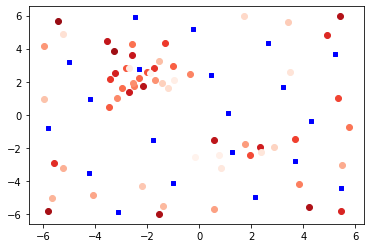

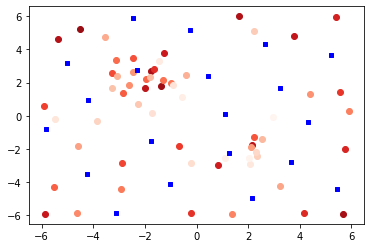

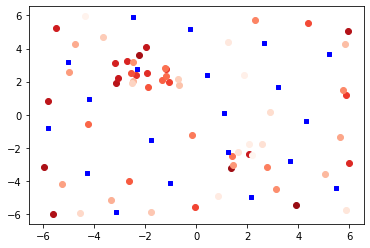

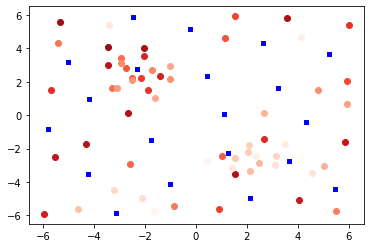

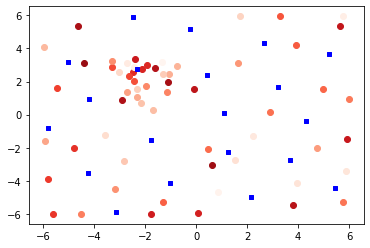

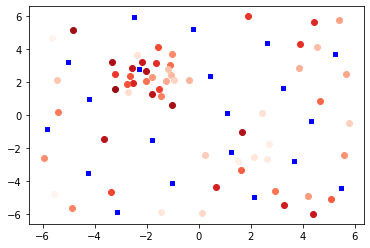

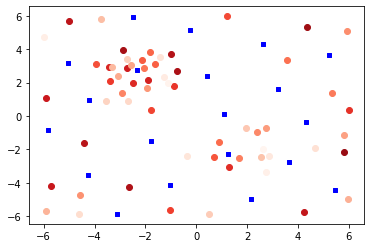

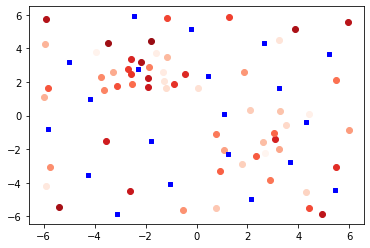

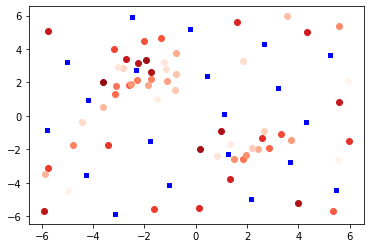

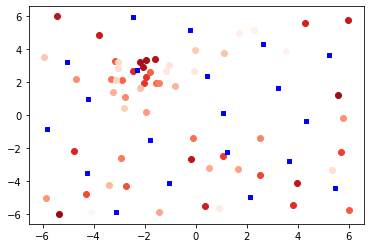

In [3]:
QBC.training(20,'D:\\Active-learning\\QBC_update\\qbc_distnace_points_0.2+0.3+0.5.txt','D:\\Active-learning\\QBC_update\\qbc_distnace_points_single_0.2+0.3+0.5loss.txt','v*mean*min')

points: 21    r2: 0.2539271015872274     rmse:  0.029337567368031694
points: 22    r2: 0.30761893300160204     rmse:  0.028262206130694096
points: 23    r2: 0.32490028186630937     rmse:  0.027907274943753394
points: 24    r2: 0.29229260573558835     rmse:  0.028573295615788977
points: 25    r2: -0.12012301267675007     rmse:  0.035947304267393725
points: 26    r2: -0.10847370006606916     rmse:  0.03575988919706707
points: 27    r2: 0.34257706126805476     rmse:  0.027539490068883194
points: 28    r2: 0.2937927771964899     rmse:  0.02854299525231831
points: 29    r2: 0.3501335882349852     rmse:  0.027380760930554124
points: 30    r2: 0.4547739234717735     rmse:  0.02507966765367795
points: 31    r2: 0.45787857318921277     rmse:  0.025008160854294376
points: 32    r2: 0.46907256496097705     rmse:  0.024748623655961113
points: 33    r2: 0.4800425280398183     rmse:  0.0244916125004082
points: 34    r2: 0.47363276207952887     rmse:  0.02464211005346628
points: 35    r2: 0.484154248

points: 79    r2: 0.650445399773941     rmse:  0.02008126090433158
points: 80    r2: 0.672743016243315     rmse:  0.019430229460057777
points: 81    r2: 0.677559662825991     rmse:  0.019286710031246768
0:01:37.667727
total points: 81    r2: 0.677559662825991     rmse:  0.019286710031246768
points: 21    r2: -0.08529128150420995     rmse:  0.035383975434999784
points: 22    r2: -0.07522483782966627     rmse:  0.03521949397176164
points: 23    r2: 0.2852261706048401     rmse:  0.02871559299939721
points: 24    r2: 0.38997412142837706     rmse:  0.026528188651089173
points: 25    r2: -0.048317549090207246     rmse:  0.034776021508238816
points: 26    r2: 0.14703007677199287     rmse:  0.03136897489164375
points: 27    r2: 0.13105478271621074     rmse:  0.03166136732617954
points: 28    r2: 0.1463285096682495     rmse:  0.0313818727188984
points: 29    r2: 0.14687160216383488     rmse:  0.03137188880161247
points: 30    r2: -0.09547965491399468     rmse:  0.035549674280793774
points: 31  

points: 74    r2: 0.6024840512873597     rmse:  0.021414638455666574
points: 75    r2: 0.6090497844630567     rmse:  0.02123705032597238
points: 76    r2: 0.6259985882508845     rmse:  0.02077160658893683
points: 77    r2: 0.6316018390235829     rmse:  0.020615420350528976
points: 78    r2: 0.6384348714516547     rmse:  0.020423338558461613
points: 79    r2: 0.6282774592242444     rmse:  0.020708226963652942
points: 80    r2: 0.6335172261715862     rmse:  0.020561758342799497
points: 81    r2: 0.639344148303826     rmse:  0.020397641723159846
0:01:35.204558
total points: 81    r2: 0.639344148303826     rmse:  0.020397641723159846
points: 21    r2: -1.0834468524417624     rmse:  0.04902579906682742
points: 22    r2: 0.0680377064869001     rmse:  0.03278933723948007
points: 23    r2: 0.12454471706616843     rmse:  0.03177974818679947
points: 24    r2: 0.4452707208178607     rmse:  0.0252972907491732
points: 25    r2: 0.47262902081519875     rmse:  0.024665594154064437
points: 26    r2: 0

points: 69    r2: 0.7600264183155542     rmse:  0.01663853882814991
points: 70    r2: 0.7648850648005034     rmse:  0.016469240689950117
points: 71    r2: 0.7531408676403074     rmse:  0.01687555508336827
points: 72    r2: 0.7564797596878984     rmse:  0.016761041430725293
points: 73    r2: 0.7611308065463422     rmse:  0.01660020836570033
points: 74    r2: 0.7605969923418344     rmse:  0.01661874671641688
points: 75    r2: 0.7111736669141213     rmse:  0.018253740030280245
points: 76    r2: 0.7190729216422964     rmse:  0.018002394273790183
points: 77    r2: 0.7257779057388527     rmse:  0.017786262163937396
points: 78    r2: 0.7330238252203352     rmse:  0.017549700968536624
points: 79    r2: 0.740267352810573     rmse:  0.01730998687942313
points: 80    r2: 0.7468296257586413     rmse:  0.017089915270497795
points: 81    r2: 0.7511343409440155     rmse:  0.016944000438669983
0:01:39.371823
total points: 81    r2: 0.7511343409440155     rmse:  0.016944000438669983
points: 21    r2: 0

points: 64    r2: 0.6336427913895131     rmse:  0.020558235581241827
points: 65    r2: 0.6338889835475892     rmse:  0.02055132685002861
points: 66    r2: 0.635025031751409     rmse:  0.020519416532096598
points: 67    r2: 0.6389472765152342     rmse:  0.020408861592050246
points: 68    r2: 0.6408145881906167     rmse:  0.020356017359983943
points: 69    r2: 0.647829539670727     rmse:  0.02015625900156082
points: 70    r2: 0.7087439952359786     rmse:  0.01833035650977449
points: 71    r2: 0.7131849770252942     rmse:  0.01819007188834847
points: 72    r2: 0.7157710120214662     rmse:  0.01810788184859259
points: 73    r2: 0.718334408723762     rmse:  0.01802604146840242
points: 74    r2: 0.7210847928301498     rmse:  0.017937815990909954
points: 75    r2: 0.7227250666029778     rmse:  0.017884992920700973
points: 76    r2: 0.721462455998672     rmse:  0.017925667590557363
points: 77    r2: 0.7236223120375779     rmse:  0.01785603207835443
points: 78    r2: 0.7258627329166804     rmse

points: 59    r2: 0.5236763141393022     rmse:  0.023441454573457428
points: 60    r2: 0.466600605936039     rmse:  0.02480617063439943
points: 61    r2: 0.4900022075751991     rmse:  0.024255912420234834
points: 62    r2: 0.5022062063539103     rmse:  0.023963939063667068
points: 63    r2: 0.5193028745558468     rmse:  0.02354882434870028
points: 64    r2: 0.5341496563209956     rmse:  0.023182308336549513
points: 65    r2: 0.5367422115098472     rmse:  0.023117711124881025
points: 66    r2: 0.556176980261019     rmse:  0.022627594106028937
points: 67    r2: 0.589462108035822     rmse:  0.021762565524693894
points: 68    r2: 0.5789916274363621     rmse:  0.022038337725770102
points: 69    r2: 0.5876313889680276     rmse:  0.021811034651567546
points: 70    r2: 0.6183909219779233     rmse:  0.020981803551999283
points: 71    r2: 0.6264640263972006     rmse:  0.02075867761658793
points: 72    r2: 0.6007225366604338     rmse:  0.021462033411366436
points: 73    r2: 0.6113616275118057    

,0,1
0,0.689335,0.018931
1,0.677560,0.019287
2,0.628599,0.020699
3,0.639344,0.020398
4,0.621150,0.020906
5,0.751134,0.016944
6,0.707758,0.018361
7,0.738902,0.017355
8,0.636924,0.020466
9,0.606145,0.021316


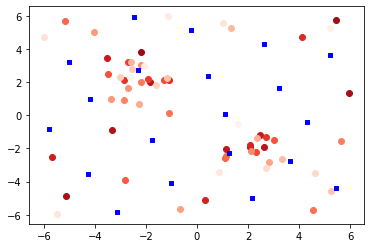

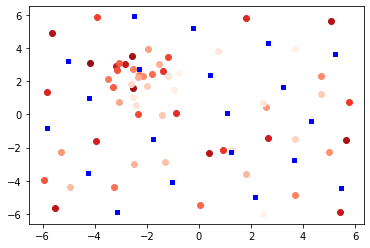

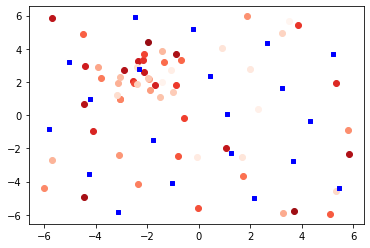

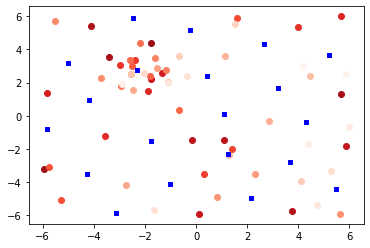

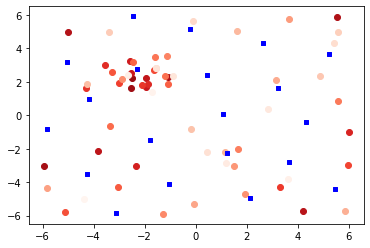

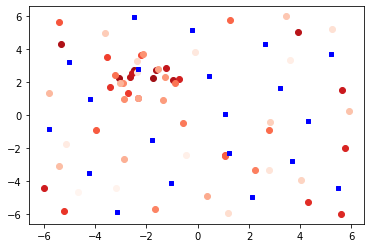

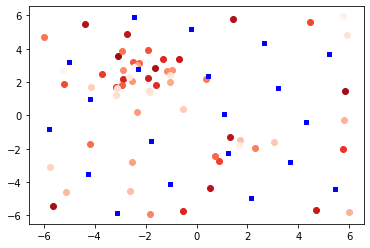

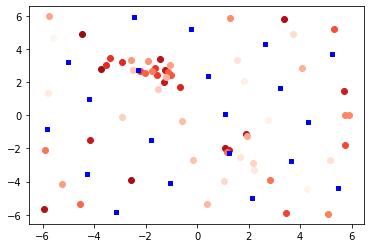

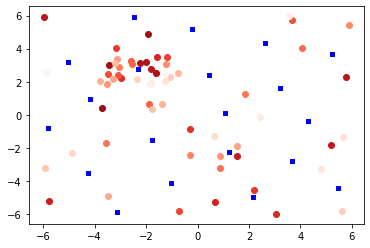

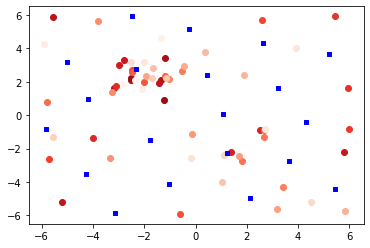

In [12]:
QBC.training(20,'D:\\Active-learning\\QBC_update\\qbc_distnace_points_vmm12.txt','D:\\Active-learning\\QBC_update\\qbc_distnace_points_single_vmm12_loss.txt','v*mean*min11')